In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import seaborn as sns

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import spacy


import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from tensorflow import random_normal_initializer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout, Reshape, Activation
import tensorflow.keras as keras
from collections import Counter
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid, RandomizedSearchCV
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from mlxtend.regressor import StackingCVRegressor

from catboost import CatBoostRegressor
from itertools import product, chain
from tqdm import tqdm
import math  

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
import shap 

import os
import tensorflow as tf
import random 

c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_data_path = 'data/train_data.csv'
test_data_path = 'data/test_data.csv'


train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [5]:
train_df.sample(5)
o_train_df = train_df

In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
X = train_df.drop('Claim', axis = 1)
y = train_df['Claim']

ros = RandomOverSampler(random_state=0)
ros.fit(X,y)
X,y = ros.fit_resample(X,y)

# Combine X_resampled and y_resampled into a new DataFrame
train_df_resampled = pd.DataFrame(X, columns=X.columns)
train_df_resampled['Claim'] = y

train_df = train_df_resampled



In [7]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11052 entries, 0 to 11051
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         11052 non-null  object 
 1   YearOfObservation   11052 non-null  int64  
 2   Insured_Period      11052 non-null  float64
 3   Residential         11052 non-null  int64  
 4   Building_Painted    11052 non-null  object 
 5   Building_Fenced     11052 non-null  object 
 6   Garden              11040 non-null  object 
 7   Settlement          11052 non-null  object 
 8   Building Dimension  10891 non-null  float64
 9   Building_Type       11052 non-null  int64  
 10  Date_of_Occupancy   10319 non-null  float64
 11  NumberOfWindows     11052 non-null  object 
 12  Geo_Code            10895 non-null  object 
 13  Claim               11052 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 1.2+ MB


In [8]:
train_df.isnull().sum()


Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                 12
Settlement              0
Building Dimension    161
Building_Type           0
Date_of_Occupancy     733
NumberOfWindows         0
Geo_Code              157
Claim                   0
dtype: int64

In [9]:
#Dealing with continous variables
train_df.describe().round(2)

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,11052.000,11052.000,11052.000,10891.000,11052.000,10319.000,11052.000
mean,2013.670,0.930,0.320,2330.560,2.260,1964.850,0.500
std,1.380,0.220,0.470,2700.370,0.970,34.880,0.500
min,2012.000,0.000,0.000,1.000,1.000,1545.000,0.000
25%,2012.000,1.000,0.000,629.000,2.000,1960.000,0.000
50%,2013.000,1.000,0.000,1332.000,2.000,1970.000,0.500
75%,2015.000,1.000,1.000,3040.000,3.000,1980.000,1.000
max,2016.000,1.000,1.000,20940.000,4.000,2016.000,1.000


In [10]:
#Duplicate Values
train_df.duplicated().sum()


3892

Editing the dataset (changing the value types)

In [11]:
train_df['Date_of_Occupancy'] = train_df['Date_of_Occupancy'].fillna(train_df['Date_of_Occupancy'].median())
train_df['Building Dimension'] = train_df['Building Dimension'].fillna(train_df['Building Dimension'].median())
train_df['Garden'] = train_df['Garden'].fillna(train_df['Garden'].mode()[0])
train_df['Geo_Code'] = train_df['Geo_Code'].fillna(train_df['Geo_Code'].mode()[0])


In [12]:
#Encoding of categorical variables We use Label Encoder
train_df['Building_Painted'] = train_df['Building_Painted'].replace(['N','V'],[1,0])
train_df['Building_Fenced'] = train_df['Building_Fenced'].replace(['N','V'],[1,0])
train_df['Garden'] = train_df['Garden'].replace(['V','O'],[1,0])
train_df['Settlement'] = train_df['Settlement'].replace(['R','U'],[0,1])
train_df['Building_Type'] = train_df['Building_Type'].replace([1,2,3,4],[0,1,2,3])

In [13]:
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace(['   .','>=10'],['',10])
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace(['','1','2','3','4','5','6','7','8','9',10],[0,1,2,3,4,5,6,7,8,9,10])


**EXPLORATORY DATA ANALYSIS**

UNIVARIATE ANALYSIS

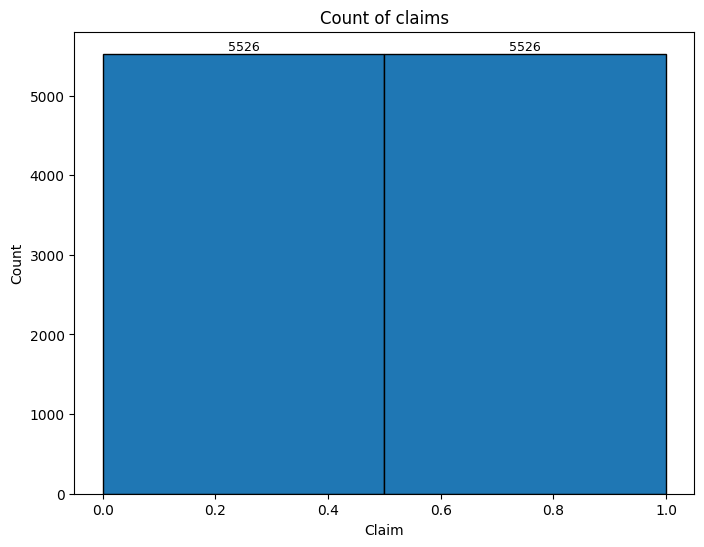

In [14]:

data = train_df['Claim']

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(data, bins=2, edgecolor='black')
# Annotate each bar with its count
hist_values, bin_edges = np.histogram(data, bins=2)
for i in range(len(hist_values)):
    plt.text(bin_edges[i] + (bin_edges[i+1] - bin_edges[i]) / 2, hist_values[i] + 2,
             str(hist_values[i]), ha='center', va='bottom', fontsize=9)

plt.title('Count of claims')
plt.xlabel('Claim')
plt.ylabel('Count')

plt.show()

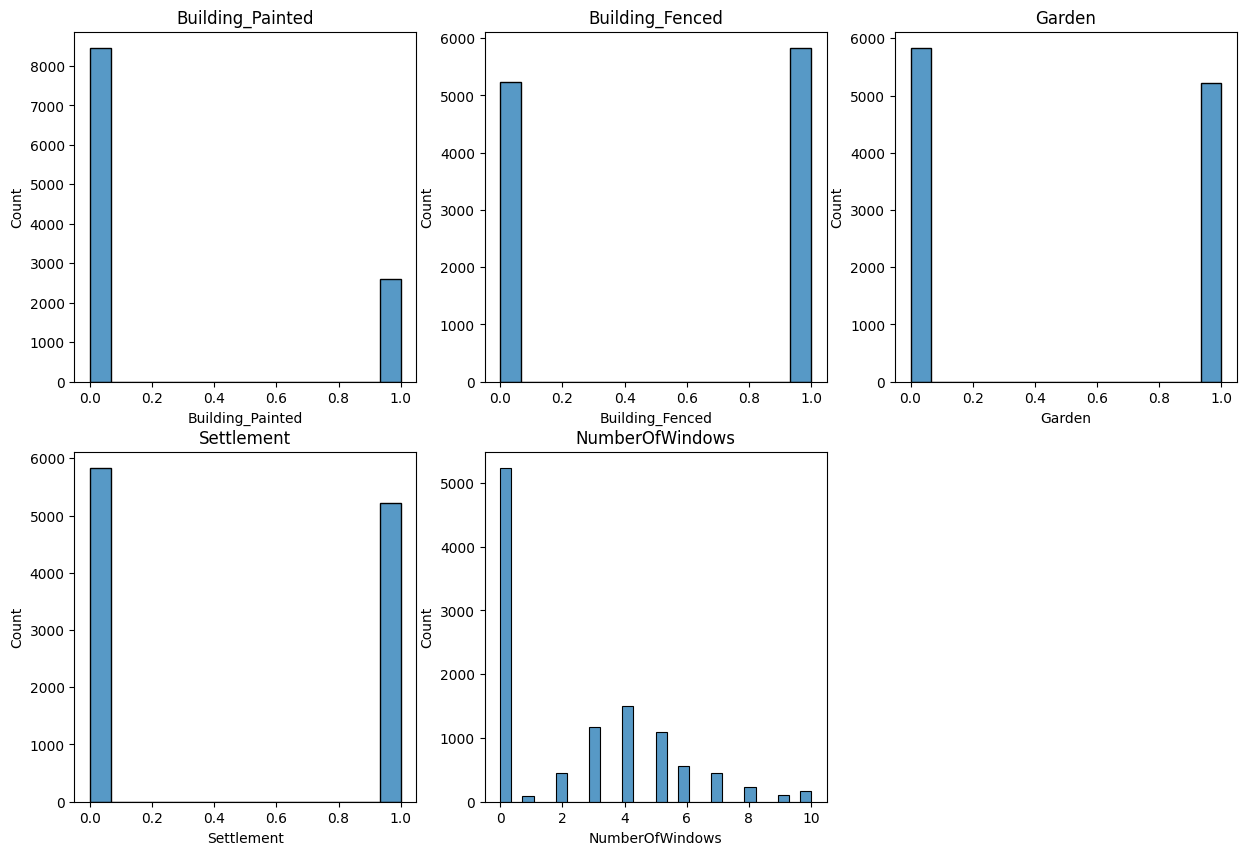

In [15]:
#Categorical Variables
train_cat = ['Building_Painted','Building_Fenced','Garden','Settlement','NumberOfWindows',]

#  plot Numerical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(15,10))

for i in train_cat:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    #plt.xlabel(i)
    sns.histplot(train_df[i])
    c = c + 1

plt.show()

C:\Users\Prachet.balaji\AppData\Local\Temp\ipykernel_21296\538211219.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[i])
C:\Users\Prachet.balaji\AppData\Local\Temp\ipykernel_21296\538211219.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[i])


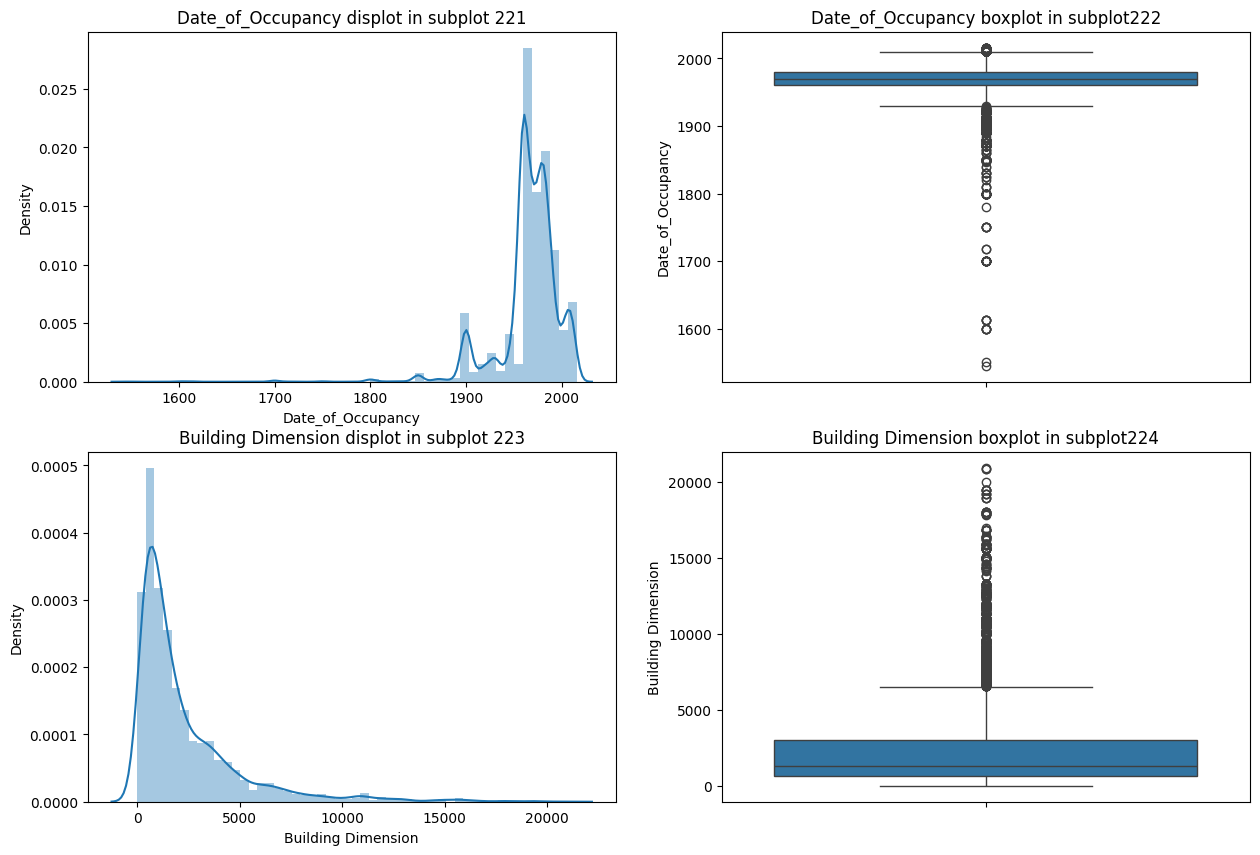

In [16]:
train_num = ['Date_of_Occupancy','Building Dimension']

a = 2
b = 2
c = 1
plt.figure(figsize=(15,10))
for i in train_num:
    plt.subplot(a,b,c)
    plt.title("{} displot in subplot {}{}{}".format(i,a,b,c))
    sns.distplot(train_df[i])
    c = c + 1

    plt.subplot(a,b,c)
    plt.title("{} boxplot in subplot{}{}{}".format(i,a,b,c))
    sns.boxplot(train_df[i])
    c = c + 1

Bivaraite Analysis

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11052 entries, 0 to 11051
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         11052 non-null  object 
 1   YearOfObservation   11052 non-null  int64  
 2   Insured_Period      11052 non-null  float64
 3   Residential         11052 non-null  int64  
 4   Building_Painted    11052 non-null  int64  
 5   Building_Fenced     11052 non-null  int64  
 6   Garden              11052 non-null  int64  
 7   Settlement          11052 non-null  int64  
 8   Building Dimension  11052 non-null  float64
 9   Building_Type       11052 non-null  int64  
 10  Date_of_Occupancy   11052 non-null  float64
 11  NumberOfWindows     11052 non-null  int64  
 12  Geo_Code            11052 non-null  object 
 13  Claim               11052 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 1.2+ MB


In [18]:
train_df_corr = train_df.drop('Customer Id', axis = 1)
train_df_corr = train_df_corr.drop('Geo_Code',axis = 1)
train_df_corr

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Claim
0,2013,1.000,0,1,0,1,1,290.000,0,1960.000,0,0
1,2015,1.000,0,0,1,0,0,490.000,0,1850.000,4,0
2,2014,1.000,0,1,0,1,1,595.000,0,1960.000,0,0
3,2013,1.000,0,0,0,1,1,2840.000,0,1960.000,0,0
4,2014,1.000,0,0,1,0,0,680.000,0,1800.000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11047,2016,1.000,0,0,1,0,0,510.000,0,1980.000,2,1
11048,2013,0.748,0,0,1,0,0,4846.000,1,2003.000,6,1
11049,2014,1.000,0,1,0,1,1,7000.000,1,1988.000,0,1
11050,2016,0.997,0,0,1,0,0,2412.000,2,2010.000,4,1


<Axes: >

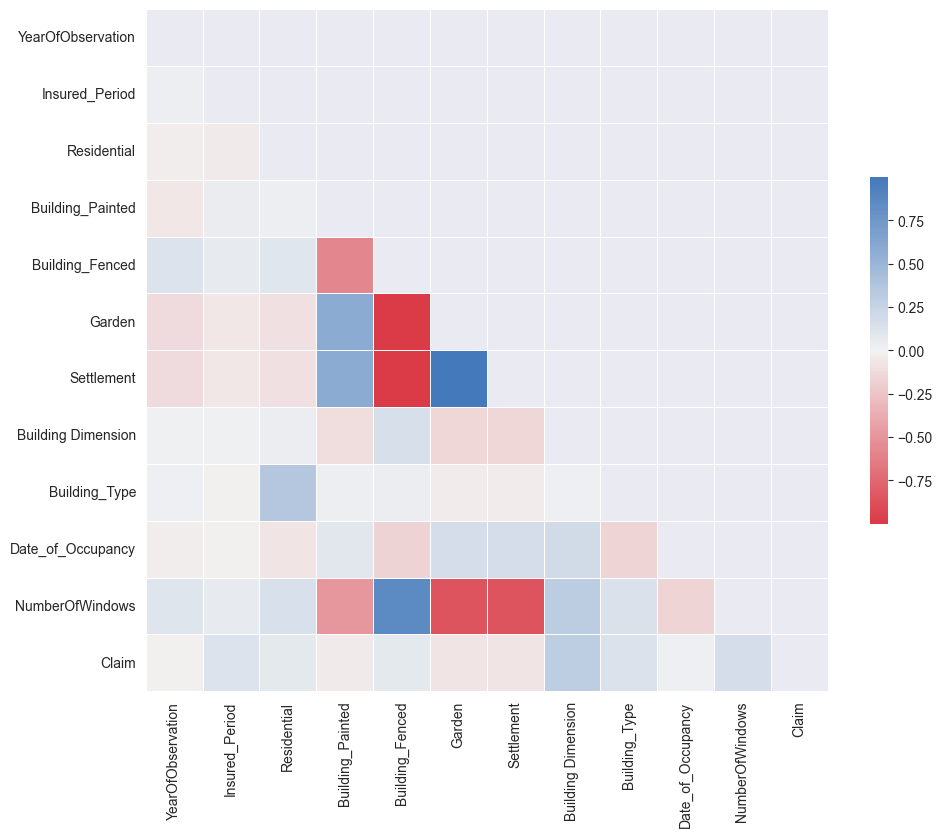

In [19]:

import seaborn as sns
# use the pandas .corr() function to compute pairwise correlations for the dataframe
corr = train_df_corr.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'dark')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [20]:
X = train_df.drop('Claim', axis = 1)
y = train_df['Claim']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [22]:
X_train=X_train.drop('Customer Id',axis = 1)
X_train=X_train.drop('Geo_Code',axis = 1)


In [23]:
train_df

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.000,0,1,0,1,1,290.000,0,1960.000,0,1053,0
1,H2037,2015,1.000,0,0,1,0,0,490.000,0,1850.000,4,1053,0
2,H3802,2014,1.000,0,1,0,1,1,595.000,0,1960.000,0,1053,0
3,H3834,2013,1.000,0,0,0,1,1,2840.000,0,1960.000,0,1053,0
4,H5053,2014,1.000,0,0,1,0,0,680.000,0,1800.000,3,1053,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11047,H4460,2016,1.000,0,0,1,0,0,510.000,0,1980.000,2,22282,1
11048,H17643,2013,0.748,0,0,1,0,0,4846.000,1,2003.000,6,69069,1
11049,H14225,2014,1.000,0,1,0,1,1,7000.000,1,1988.000,0,77053,1
11050,H19081,2016,0.997,0,0,1,0,0,2412.000,2,2010.000,4,64189,1


In [24]:
X_train

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows
1502,2012,1.000,0,1,0,1,1,1410.000,1,1960.000,0
4089,2015,1.000,0,1,0,1,1,1754.000,2,1960.000,0
10531,2015,1.000,1,0,1,0,0,850.000,2,1960.000,4
4602,2012,1.000,0,0,0,1,1,1387.000,0,1988.000,0
4567,2014,1.000,0,0,0,1,1,450.000,0,1988.000,0
...,...,...,...,...,...,...,...,...,...,...,...
4859,2013,1.000,0,1,0,1,1,2290.000,0,1980.000,0
3264,2014,1.000,0,0,1,0,0,4500.000,0,1962.000,10
9845,2016,1.000,0,0,1,0,0,890.000,0,1970.000,3
10799,2013,1.000,1,0,1,0,0,741.000,1,1900.000,4


In [25]:

features = train_df.columns.tolist()
features.remove('Claim')
features.remove('Customer Id')
features.remove('Geo_Code')
features

['YearOfObservation',
 'Insured_Period',
 'Residential',
 'Building_Painted',
 'Building_Fenced',
 'Garden',
 'Settlement',
 'Building Dimension',
 'Building_Type',
 'Date_of_Occupancy',
 'NumberOfWindows']

In [26]:
from scipy.stats import pointbiserialr
from math import sqrt

def getMerit(subset, label):
    k = len(subset)

    # average feature-class correlation
    rcf_all = []
    for feature in subset:
        coeff = pointbiserialr(train_df[label], train_df[feature] )
        rcf_all.append( abs( coeff.correlation ) )
    rcf = np.mean( rcf_all )

    # average feature-feature correlation
    corr = train_df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()

    return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [27]:
best_value = -1
best_feature = ''
for feature in features:
    coeff = pointbiserialr(y_train, X_train[feature] )
    abs_coeff = abs( coeff.correlation )
    if abs_coeff > best_value:
        best_value = abs_coeff
        best_feature = feature

print("Feature %s with merit %.4f"%(best_feature, best_value))


Feature Building Dimension with merit 0.3055


In [28]:
class PriorityQueue:
    def  __init__(self):
        self.queue = []

    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        """
        item already in priority queue with smaller priority:
        -> update its priority
        item already in priority queue with higher priority:
        -> do nothing
        if item not in priority queue:
        -> push it
        """
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append( (item, priority) )
                break
        else:
            self.queue.append( (item, priority) )
        
    def pop(self):
        # return item with highest priority and remove it from queue
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

In [29]:
# initialize queue
queue = PriorityQueue()

# push first tuple (subset, merit)
queue.push([best_feature], best_value)

In [30]:
# list for visited nodes
visited = []

# counter for backtracks
n_backtrack = 0

# limit of backtracks
max_backtrack = 100


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11052 entries, 0 to 11051
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         11052 non-null  object 
 1   YearOfObservation   11052 non-null  int64  
 2   Insured_Period      11052 non-null  float64
 3   Residential         11052 non-null  int64  
 4   Building_Painted    11052 non-null  int64  
 5   Building_Fenced     11052 non-null  int64  
 6   Garden              11052 non-null  int64  
 7   Settlement          11052 non-null  int64  
 8   Building Dimension  11052 non-null  float64
 9   Building_Type       11052 non-null  int64  
 10  Date_of_Occupancy   11052 non-null  float64
 11  NumberOfWindows     11052 non-null  int64  
 12  Geo_Code            11052 non-null  object 
 13  Claim               11052 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 1.2+ MB


In [32]:
# repeat until queue is empty
# # or the maximum number of backtracks is reached

# while not queue.isEmpty():
#     # get element of queue with highest merit
#     subset, priority = queue.pop()
    
#     # check whether the priority of this subset
#     # is higher than the current best subset
#     if (priority < best_value):
#         n_backtrack += 1
#     else:
#         best_value = priority
#         best_subset = subset

#     # goal condition
#     if (n_backtrack == max_backtrack):
#         break
    
#     # iterate through all features and look of one can
#     # increase the merit
#     for feature in features:
#         if feature not in subset:
#             temp_subset = subset + [feature]
        
#         # check if this subset has already been evaluated
#         for node in visited:
#             if (set(node) == set(temp_subset)):
#                 break
#         # if not, ...
#         else:
#             # ... mark it as visited
#             visited.append( temp_subset )
#             # ... compute merit
#             merit = getMerit(temp_subset, 'Claim')
#             # print(merit)
#             # print(temp_subset)

            
#             # and push it to the queue
#             queue.push(temp_subset, merit)





# Ensure queue and visited are properly initialized
# Assume visited is a set to store frozensets of subsets for fast lookup

best_value = float('-inf')  # Initialize with a very low value
best_subset = ['Building Dimension']
n_backtrack = 0
max_backtrack = 10000  # Set to your desired max backtracks


visited = set()
queue = PriorityQueue()

# Initialize the queue with the best feature (assuming best_feature is already determined)
initial_subset = best_subset
initial_merit = getMerit(initial_subset, 'Claim')
queue.push(initial_subset, initial_merit)
visited.add(frozenset(initial_subset))

# Repeat until queue is empty or the maximum number of backtracks is reached
while not queue.isEmpty():
    # Get element of queue with highest merit
    subset, priority = queue.pop()
    
    # Check whether the priority of this subset is higher than the current best subset
    if priority < best_value:
        n_backtrack += 1
    else:
        best_value = priority
        best_subset = subset

    # Goal condition
    if n_backtrack == max_backtrack:
        break
    
    # Iterate through all features and check if one can increase the merit
    for feature in features:
        if feature not in subset:
            temp_subset = subset + [feature]
            temp_frozenset = frozenset(temp_subset)
        
            # Check if this subset has already been evaluated
            if temp_frozenset not in visited:
                # Mark it as visited
                visited.add(temp_frozenset)
            
                # Compute merit
                merit = getMerit(temp_subset, 'Claim')
                print(merit)
                # Push it to the queue
                queue.push(temp_subset, merit)

# Return the best subset based on the best merit
print("Best Subset:", best_subset)
print("Best Merit Value:", best_value)


# Best Subset: ['Building_Type', 'Building Dimension']
# Best Merit Value: 0.2869903439496809

0.21877201027456036
0.2978914996271592


0.257801022548218
0.2323231713861455
0.24588406243380223
0.24626069343572327
0.24614875590569207
0.30318330140599214
0.20749709797579347
0.2871086188197523
0.25251283885911324
0.3168201251940071
0.2578823327849284
0.2631528540167325
0.2740612261798732
0.2743813771870385
0.2742926784105571
0.23416716121499137
0.3014619547804559
0.27719035073560067
0.28222777522154796
0.2860130247219091
0.2943652582964681
0.29462792270361043
0.29458330403736305
0.2627219281587521
0.3197337326131971
0.2894670090391382
0.2945843951192836
0.2813086144951366
0.2759545238804056
0.2760963880970324
0.2760594535449975
0.2775045586359828
0.2672835186611193
0.27308699269852954
0.2584575527086372
0.25336544565365393
0.2535265719252156
0.2534681251851839
0.25325050205962246
0.24705581735278273
0.2778301586843616
0.25786228380136555
0.26777682126511804
0.2680687491183582
0.2680158337600525
0.23966841748047718
0.3037715500824382
0.26728871984634994
0.28956759815528493
0.2580464612073668
0.2522409574867711
0.2523911929

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
import time

# predictors
X_train_svm_o = X_train[features].to_numpy()
# target
y_train_svm_o = y_train.to_numpy()

# get timing
t0 = time.time()

# run SVM with 10-fold cross validation
svc = svm.SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
scores = cross_val_score(svc, X_train_svm_o, y_train_svm_o, cv=10)
best_score = np.mean( scores )

print("Score: %.2f%% (Time: %.4f s)"%(best_score*100, time.time() - t0))

# Output
# Score: 67.65 Time 48 s

Score: 82.14% (Time: 60.6651 s)


In [34]:
X_train

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows
1502,2012,1.000,0,1,0,1,1,1410.000,1,1960.000,0
4089,2015,1.000,0,1,0,1,1,1754.000,2,1960.000,0
10531,2015,1.000,1,0,1,0,0,850.000,2,1960.000,4
4602,2012,1.000,0,0,0,1,1,1387.000,0,1988.000,0
4567,2014,1.000,0,0,0,1,1,450.000,0,1988.000,0
...,...,...,...,...,...,...,...,...,...,...,...
4859,2013,1.000,0,1,0,1,1,2290.000,0,1980.000,0
3264,2014,1.000,0,0,1,0,0,4500.000,0,1962.000,10
9845,2016,1.000,0,0,1,0,0,890.000,0,1970.000,3
10799,2013,1.000,1,0,1,0,0,741.000,1,1900.000,4


In [35]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 

# predictors
X= X_train[best_subset].to_numpy()
Y = y_train
X_t = X_test[best_subset].to_numpy()
y_t = y_test
# get timing
t0 = time.time()

# run SVM with 10-fold cross validation
svc = svm.SVC(kernel='rbf', C=100, gamma=0.01, random_state=60)
scores_subset = cross_val_score(svc, X, Y, cv=10)
best_score = np.mean( scores_subset )

print("Score: %.2f%% (Time: %.4f s)"%(best_score*100, time.time() - t0))
# print prediction results 
svc.fit(X,Y)
predictions = svc.predict(X_t) 
print(classification_report(y_t, predictions)) 
# Output
# Score: 75.73 Time 36 s c =10 rbf g = 0.01 and rs = 60
# Score : 76.9 Time 4 s kernel='sigmoid', C=10, gamma=0.1, random_state=60 // not valid since 0 recall and precision on one class(overfitting on one class)

Score: 72.97% (Time: 66.6034 s)
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      1618
           1       0.73      0.75      0.74      1698

    accuracy                           0.73      3316
   macro avg       0.73      0.73      0.73      3316
weighted avg       0.73      0.73      0.73      3316



In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1,0.5, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
grid.fit(X, Y) 
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(X_t) 
  
# print classification report 
print(classification_report(y_t, grid_predictions)) 


###AFTER HYPERPARAMETER TUNING : {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.537 total time=   4.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.568 total time=   3.8s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.562 total time=   4.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.544 total time=   3.8s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.565 total time=   4.5s
[CV 1/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.626 total time=   4.7s
[CV 2/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.648 total time=   4.5s
[CV 3/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.683 total time=   5.6s
[CV 4/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.633 total time=   3.9s
[CV 5/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.643 total time=   4.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.620 total time=   4.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# predictors
X= X_train[best_subset].to_numpy()
Y = y_train
X_t = X_test[best_subset].to_numpy()
y_t = y_test
#Random Forest Classifier with 10 fold estimators
rfc = RandomForestClassifier(n_estimators=10000)
rfc_fit = rfc.fit(X, Y)
rfc_predicted = rfc.predict(X_t)
rfc_probs = rfc.predict_proba(X_t)[:, 1]

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_auc_score
# calculate roc auc
rfc_roc_value = roc_auc_score(y_t, rfc_probs)
rfc_roc_value


0.8767300219410316

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_t,rfc_predicted))

              precision    recall  f1-score   support

           0       0.85      0.71      0.77      1618
           1       0.76      0.88      0.82      1698

    accuracy                           0.80      3316
   macro avg       0.81      0.80      0.80      3316
weighted avg       0.81      0.80      0.80      3316



***MAIN END***

In [ ]:
train_df['Garden'] = train_df['Garden'].fillna(train_df['Garden'].mode()[0])
train_df['Geo_Code'] = train_df['Geo_Code'].fillna(train_df['Geo_Code'].mode()[0])


In [ ]:
train_df.isnull().sum()


Customer Id           0
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
NumberOfWindows       0
Geo_Code              0
Claim                 0
dtype: int64

DATA ANALYSIS

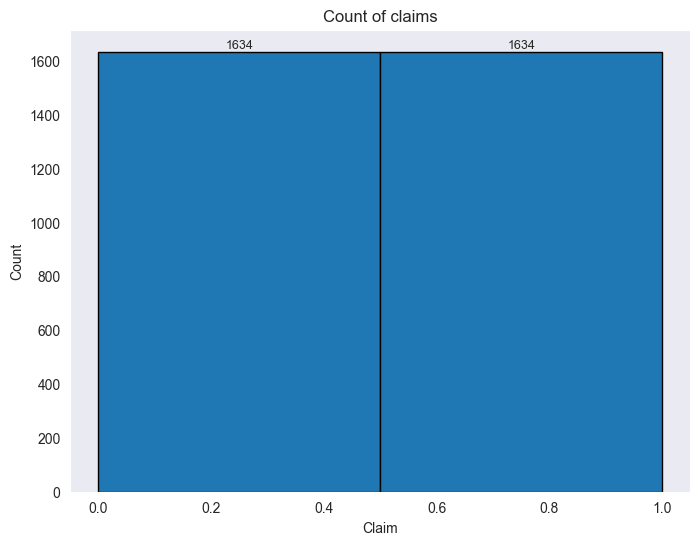

In [ ]:

data = train_df['Claim']

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(data, bins=2, edgecolor='black')

# Annotate each bar with its count
hist_values, bin_edges = np.histogram(data, bins=2)
for i in range(len(hist_values)):
    plt.text(bin_edges[i] + (bin_edges[i+1] - bin_edges[i]) / 2, hist_values[i] + 2,
             str(hist_values[i]), ha='center', va='bottom', fontsize=9)

plt.title('Count of claims')
plt.xlabel('Claim')
plt.ylabel('Count')

plt.show()

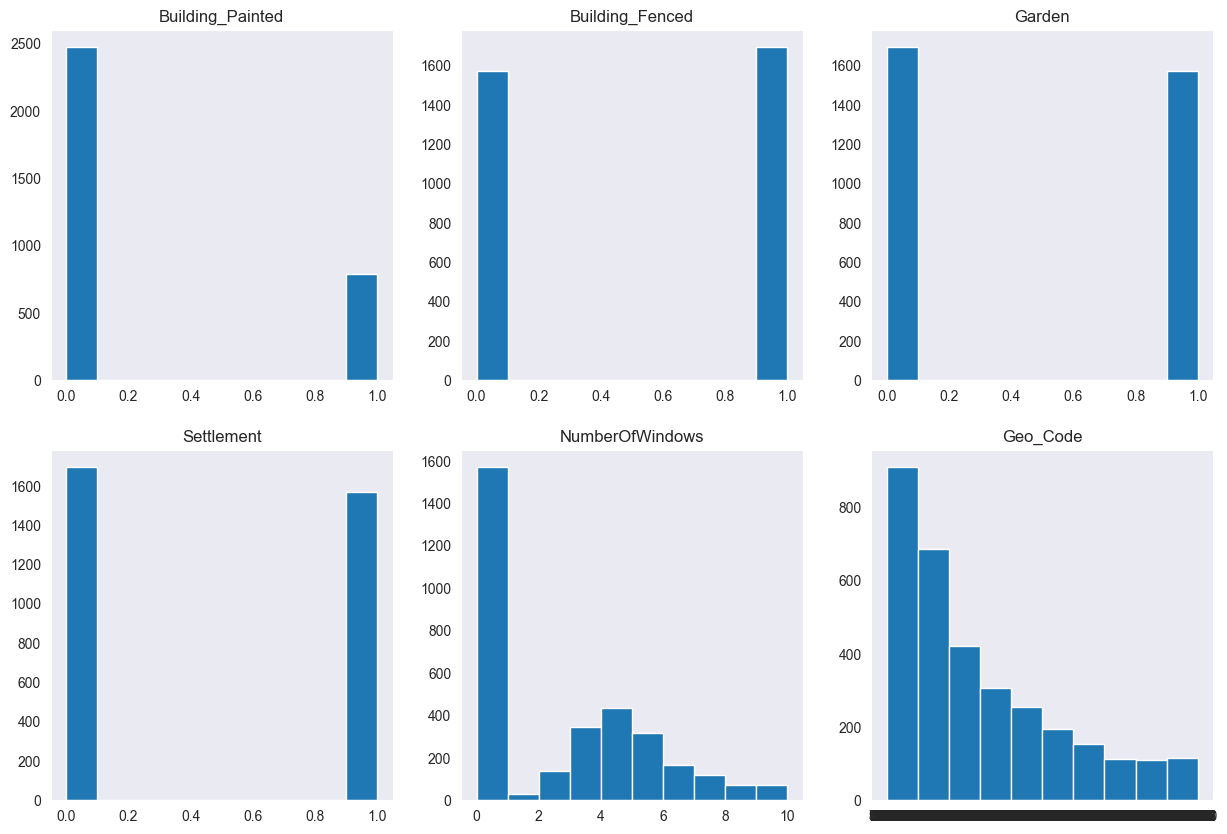

In [ ]:
#Categorical Variables
train_cat = ['Building_Painted','Building_Fenced','Garden','Settlement','NumberOfWindows','Geo_Code']

#  plot Numerical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(15,10))

for i in train_cat:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    #plt.xlabel(i)
    plt.hist(train_df[i])
    c = c + 1

plt.show()

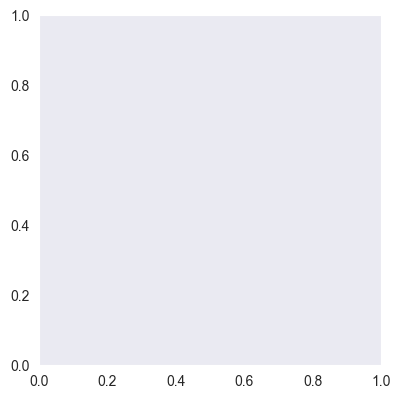

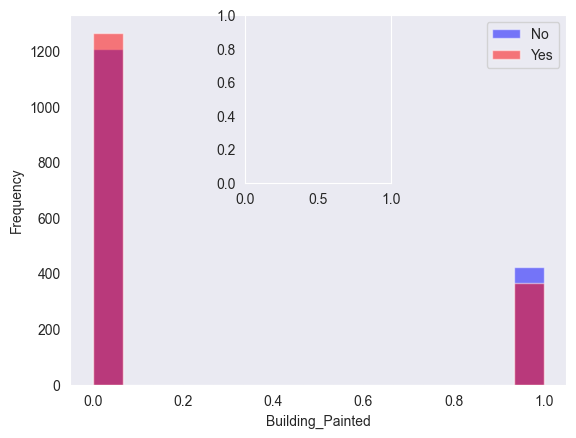

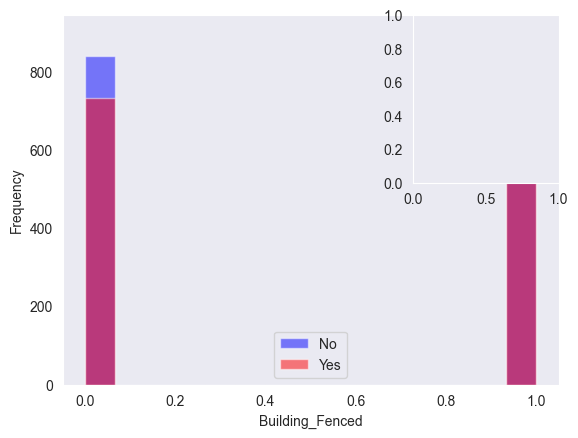

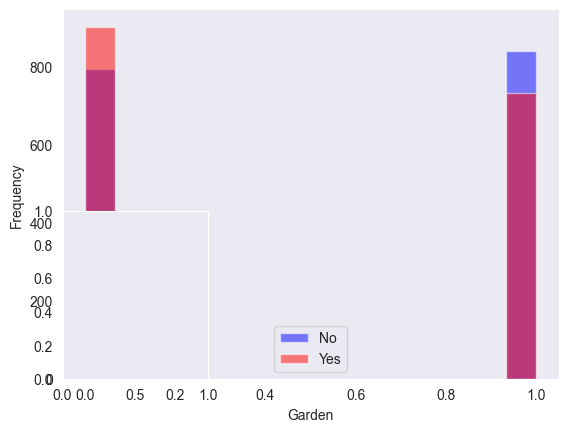

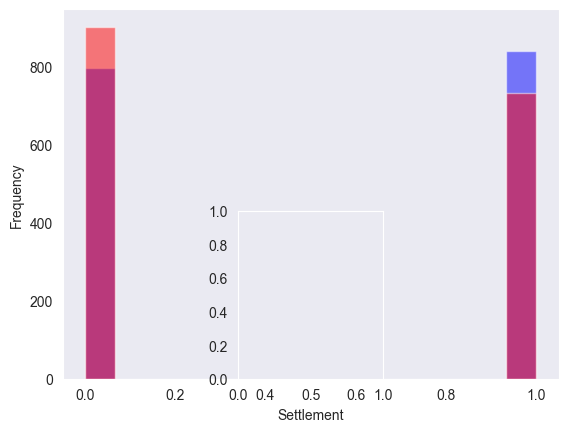

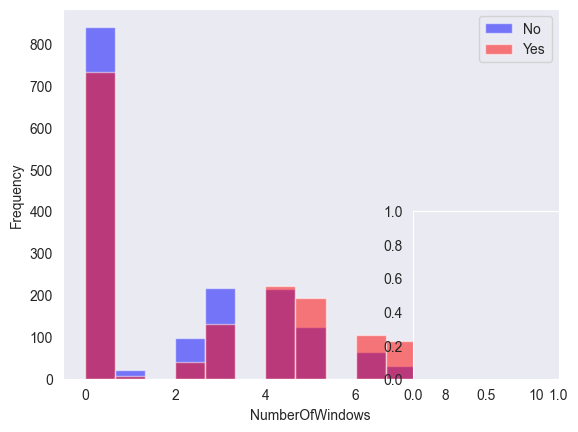

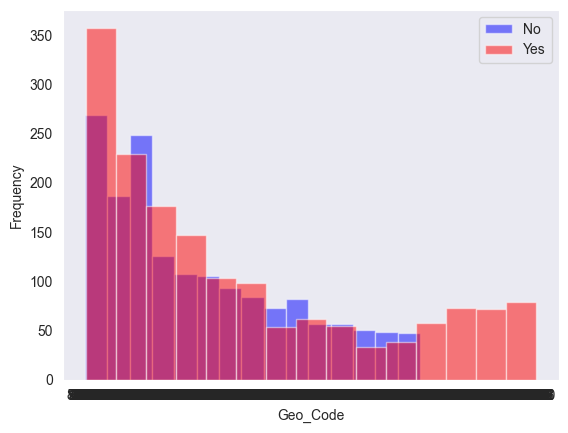

In [ ]:
#  plot Numerical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(15,10))

for i in train_cat:
    plt.subplot(a, b, c)
    fig, ax = plt.subplots()

    ax.hist(train_df[train_df['Claim']==0][i], bins=15, alpha=0.5, color="blue", label="No")
    ax.hist(train_df[train_df['Claim']==1][i], bins=15, alpha=0.5, color="red", label="Yes")

    ax.set_xlabel(i)
    ax.set_ylabel("Frequency")

    ax.legend()
    c = c+1
    

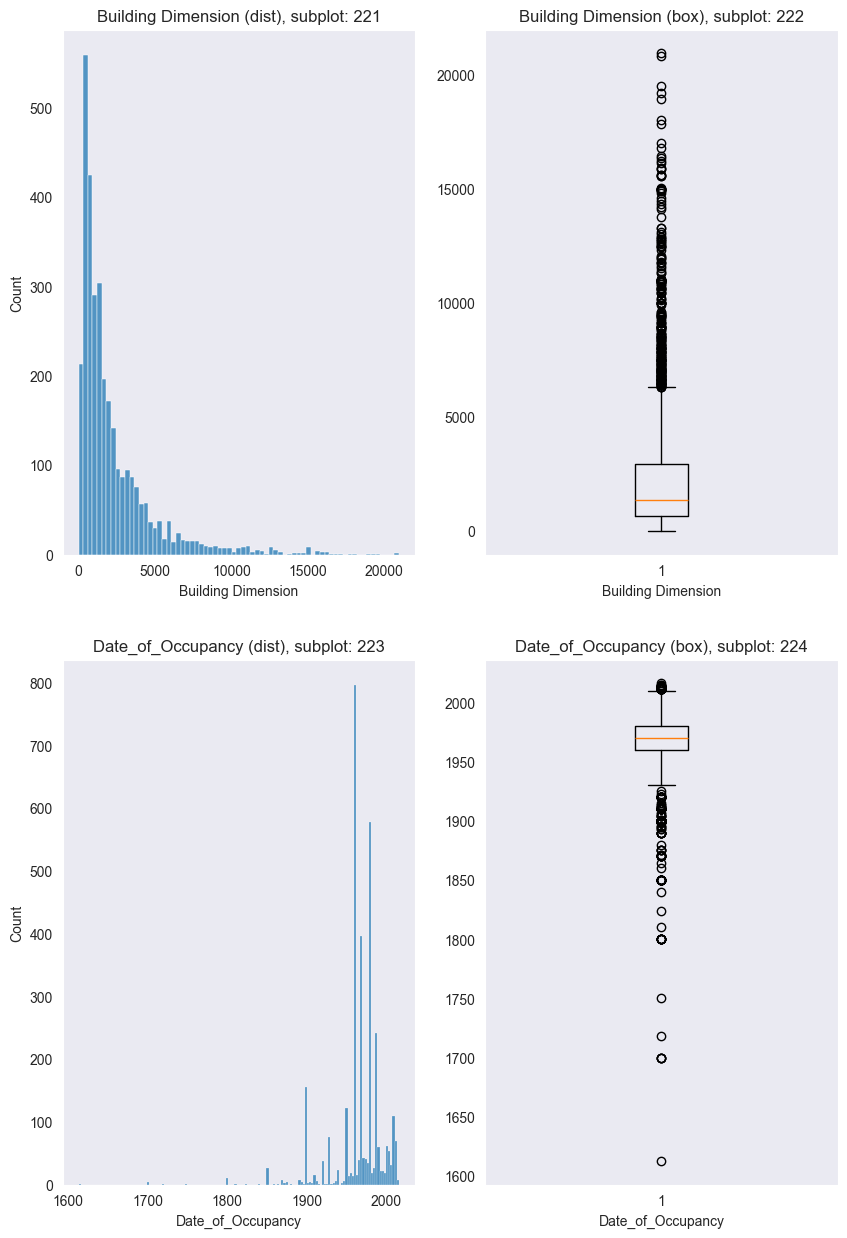

In [ ]:
#Numerical Data
train_num = ['Building Dimension', 'Date_of_Occupancy']

#  plot Numerical Data
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(10,15))

for i in train_num:
    plt.subplot(a, b, c)
    plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.histplot(train_df[i])
    c = c + 1

    plt.subplot(a, b, c)
    plt.title('{} (box), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    plt.boxplot(x = train_df[i])
    c = c + 1

    #plt.subplot(a, b, c)
    #plt.title('{} (scatter), subplot: {}{}{}'.format(i, a, b, c))
    #plt.xlabel(i)
    #sns.scatterplot(data = train_df, x = i, y = 'chol', hue = 'claim')
    #c = c + 1

plt.show()

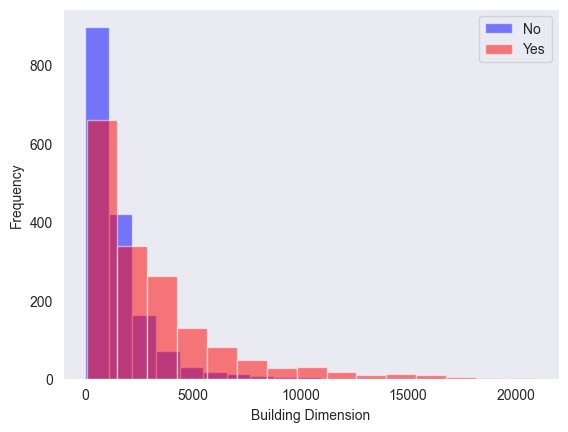

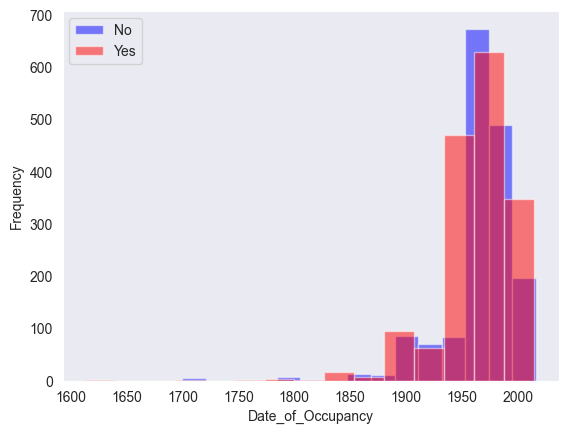

In [ ]:
for i in train_num:
    
    fig, ax = plt.subplots()

    ax.hist(train_df[train_df['Claim']==0][i], bins=15, alpha=0.5, color="blue", label="No")
    ax.hist(train_df[train_df['Claim']==1][i], bins=15, alpha=0.5, color="red", label="Yes")

    ax.set_xlabel(i)
    ax.set_ylabel("Frequency")

    ax.legend()
    

FEATURE ENGINEERING

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3268 entries, 18 to 7156
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         3268 non-null   object 
 1   YearOfObservation   3268 non-null   int64  
 2   Insured_Period      3268 non-null   float64
 3   Residential         3268 non-null   int64  
 4   Building_Painted    3268 non-null   int64  
 5   Building_Fenced     3268 non-null   int64  
 6   Garden              3268 non-null   int64  
 7   Settlement          3268 non-null   int64  
 8   Building Dimension  3268 non-null   float64
 9   Building_Type       3268 non-null   int64  
 10  Date_of_Occupancy   3268 non-null   float64
 11  NumberOfWindows     3268 non-null   int64  
 12  Geo_Code            3268 non-null   object 
 13  Claim               3268 non-null   int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 383.0+ KB


In [ ]:
train_df.describe().round()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Claim
count,3268.000,3268.000,3268.000,3268.000,3268.000,3268.000,3268.000,3268.000,3268.000,3268.000,3268.000,3268.000
mean,2014.000,1.000,0.000,0.000,1.000,0.000,0.000,2304.000,1.000,1966.000,2.000,0.000
std,1.000,0.000,0.000,0.000,0.000,0.000,0.000,2693.000,1.000,32.000,3.000,1.000
min,2012.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1613.000,0.000,0.000
25%,2012.000,1.000,0.000,0.000,0.000,0.000,0.000,650.000,1.000,1960.000,0.000,0.000
50%,2013.000,1.000,0.000,0.000,1.000,0.000,0.000,1345.000,1.000,1970.000,2.000,0.000
75%,2015.000,1.000,1.000,0.000,1.000,1.000,1.000,2910.000,2.000,1980.000,4.000,1.000
max,2016.000,1.000,1.000,1.000,1.000,1.000,1.000,20940.000,3.000,2016.000,10.000,1.000


In [ ]:
#Step 1 is correcting the outliers in the insured years column, we can impute all data above 8 to be equal to 8

train_df['Insured_Period'] = train_df['Insured_Period'].apply(lambda x : 8 if x > 8 else x)

In [ ]:
#Encoding of categorical variables We use Label Encoder
train_df['Building_Painted'] = train_df['Building_Painted'].replace(['N','V'],[1,0])
train_df['Building_Fenced'] = train_df['Building_Fenced'].replace(['N','V'],[1,0])
train_df['Garden'] = train_df['Garden'].replace(['V','O'],[1,0])
train_df['Settlement'] = train_df['Settlement'].replace(['R','U'],[0,1])
train_df['Building_Type'] = train_df['Building_Type'].replace([1,2,3,4],[0,1,2,3])


In [ ]:
train_df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
18,H19461,2015,1.000,0,0,1,0,0,2444.000,0,1970.000,5,2059,0
5959,H5929,2014,1.000,0,1,0,1,1,336.000,0,1960.000,0,85194,0
4938,H18493,2013,1.000,0,0,1,0,0,1975.000,2,1900.000,8,75108,0
6577,H14087,2013,0.263,1,1,0,1,1,216.000,1,1980.000,0,93015,0
3855,H19244,2015,1.000,0,0,1,0,0,600.000,0,1960.000,5,63113,0


In [ ]:
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace(['   .','>=10'],['',10])
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace(['1','2','3','4','5','6','7','8','9',10],[0,1,2,3,4,5,6,7,8,9])


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3268 entries, 18 to 7156
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         3268 non-null   object 
 1   YearOfObservation   3268 non-null   int64  
 2   Insured_Period      3268 non-null   float64
 3   Residential         3268 non-null   int64  
 4   Building_Painted    3268 non-null   int64  
 5   Building_Fenced     3268 non-null   int64  
 6   Garden              3268 non-null   int64  
 7   Settlement          3268 non-null   int64  
 8   Building Dimension  3268 non-null   float64
 9   Building_Type       3268 non-null   int64  
 10  Date_of_Occupancy   3268 non-null   float64
 11  NumberOfWindows     3268 non-null   int64  
 12  Geo_Code            3268 non-null   object 
 13  Claim               3268 non-null   int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 383.0+ KB


In [ ]:
train_df

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
18,H19461,2015,1.000,0,0,1,0,0,2444.000,0,1970.000,5,2059,0
5959,H5929,2014,1.000,0,1,0,1,1,336.000,0,1960.000,0,85194,0
4938,H18493,2013,1.000,0,0,1,0,0,1975.000,2,1900.000,8,75108,0
6577,H14087,2013,0.263,1,1,0,1,1,216.000,1,1980.000,0,93015,0
3855,H19244,2015,1.000,0,0,1,0,0,600.000,0,1960.000,5,63113,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7145,H2241,2014,1.000,0,0,0,1,1,1345.000,0,1985.000,0,6088,1
7148,H3598,2012,0.945,0,0,0,1,1,1345.000,0,1960.000,0,6088,1
7152,H5016,2012,1.000,0,0,0,1,1,1345.000,0,2001.000,0,6088,1
7154,H5142,2012,1.000,0,0,0,1,1,1345.000,0,2001.000,0,6088,1


In [ ]:
train_df.isnull().sum()

Customer Id           0
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
NumberOfWindows       0
Geo_Code              0
Claim                 0
dtype: int64

In [ ]:
#Checking cardinality (Number of unique values in a column)
# Get a list of the categorical variables

object_cols = [col for col in train_df.columns if train_df[col].dtype == "object"]

# Get number of unique entries in each column with categorical data

object_nunique = list(map(lambda col: train_df[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order

sorted(d.items(), key=lambda x: x[1])

[('Geo_Code', 872), ('Customer Id', 3268)]

In [ ]:
train_df_corr = train_df.drop('Customer Id', axis = 1)
import seaborn as sns
# use the pandas .corr() function to compute pairwise correlations for the dataframe
corr = train_df_corr.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'dark')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

ValueError: could not convert string to float: '2A004'

UNIVARIATE ANALYSIS

NameError: name 'train_data' is not defined

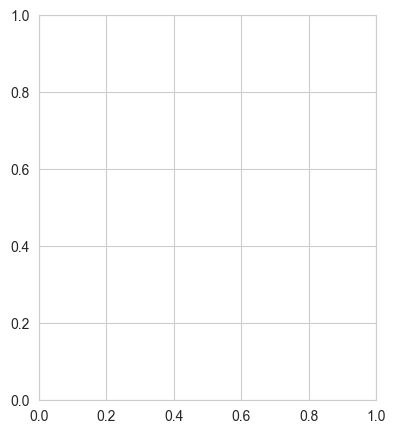

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,5))


plt.subplot(1,4,1)
sns.countplot(x = "YearOfObservation" ,hue="Claim", data=train_df, palette="dark")
plt.xticks(rotation=90)
plt.title("Claim against Year of Obeservation")

plt.subplot(1,4,2)
sns.countplot(x = "Claim" ,hue="Building_Fenced", data=train_df, palette="dark")
plt.xticks(rotation=90)
plt.title("Claim against Fenced Buildings")

plt.subplot(1,4,3)
sns.countplot(x = "Claim" ,hue="Residential", data=train_df, palette="dark")
plt.xticks(rotation=90)
plt.title("Claim against Residential Type")

plt.subplot(1,4,4)
sns.countplot(x = "Claim" ,hue="Building_Painted", data=train_data, palette="dark")
plt.xticks(rotation=90)
plt.title("Claim against Painted Buildings")

          
plt.show()